In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as Fun
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# try running the following code, if you see errors on Windows OS
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [3]:
import pandas as pd
import numpy as np

# File to Load (Remember to Change These)
file_to_load = "data\PendulumData.csv"

# Read Purchasing File and store into Pandas data frame
pendulum_csv = pd.read_csv(file_to_load,header=None)
pendulum_csv.head()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,...,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000
1,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,...,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000
2,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,...,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000,30.000
3,29.999,29.999,29.999,29.999,29.999,29.999,29.999,29.999,29.999,29.999,...,29.999,29.999,29.999,29.999,29.999,29.999,29.999,29.999,29.999,29.999
4,29.998,29.998,29.998,29.999,29.999,29.999,29.999,29.999,29.999,29.999,...,29.999,29.999,29.999,29.999,29.999,29.999,29.999,29.999,29.999,29.999


In [4]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
pendulum_csv=mms.fit_transform(pendulum_csv.iloc[:])
pendulum_csv

array([[0.97673377, 0.97777956, 0.9786896 , ..., 0.99377518, 0.99393889,
        0.99408616],
       [0.97673377, 0.97777956, 0.9786896 , ..., 0.99377518, 0.99393889,
        0.99408616],
       [0.97673377, 0.97777956, 0.9786896 , ..., 0.99377518, 0.99393889,
        0.99408616],
       ...,
       [0.01776548, 0.2461711 , 0.55136801, ..., 0.37159699, 0.47960198,
        0.58019195],
       [0.0172378 , 0.24487344, 0.54995106, ..., 0.37080279, 0.47880264,
        0.57942547],
       [0.0167261 , 0.24357578, 0.54853411, ..., 0.37000859, 0.47800495,
        0.57865733]])

In [5]:
nm=11
nl=11
m0=1
l0=1
deltal=0.1
deltam=0.1
t=np.arange(0,5/5,0.001/5)
l_np=np.arange(l0-l0,nl*deltal/l0,deltal)
m_np=np.arange(m0-m0,nm*deltam/m0,deltam)

X=[]
Y=[]
for i in range(1,nl+1):
    for j in range(1,nm+1):
        preX=np.column_stack((t,l_np[i-1].repeat(len(t)),m_np[j-1].repeat(len(t))))
        X.append(preX)
        Y.append(pendulum_csv[:,nl*(i-1)+j-1])
X_array=np.array(X)
X=X_array.reshape(605000,3)
Y_array=np.array(Y)
Y=Y_array.reshape(605000,1)


In [6]:
import random
index = [i for i in range(len(Y))] 
random.shuffle(index)
X = X[index,:]
Y = Y[index,:]

In [7]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)
X.shape, Y.shape

(torch.Size([605000, 3]), torch.Size([605000, 1]))

In [8]:
N=-100000
X_train, X_test = X[:N], X[N:]
Y_train, Y_test = Y[:N], Y[N:]
trainloader = DataLoader(TensorDataset(X_train, Y_train), 512, True)
X_train.shape, X_test.shape

(torch.Size([505000, 3]), torch.Size([100000, 3]))

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [10]:
# 定义模型类
#class MyDNN(nn.Module):
#    def __init__(self):
#        super(MyDNN, self).__init__()
#        self.fc1 = nn.Linear(3, 512)
#        self.fc2 = nn.Linear(256, 32)
#        self.fc3 = nn.Linear(128, 1)
#        self.relu = nn.ReLU()
#        self.sigmoid = nn.Sigmoid()

#    def forward(self, x):
#        x = self.relu(self.fc1(x))
#        x = self.relu(self.fc2(x))
#        x = self.sigmoid(self.fc3(x))
#        return x

In [11]:
class MyDNN(nn.Module):
    def __init__(self, input_size, hiddens=[256, 256, 256]):
        super().__init__()
        self.hiddens = hiddens
        self.net = nn.Sequential(nn.Flatten())
        for pre, nxt in zip([input_size]+hiddens[:-1], hiddens):
            self.net.add_module(str(len(self.net)),nn.Linear(pre, nxt))
            self.net.add_module(str(len(self.net)),nn.ReLU())
        self.net.add_module(str(len(self.net)),nn.Linear(hiddens[-1], 1))
        
    def forward(self, x):
        return self.net(x)

In [12]:
# 创建模型实例
modelDNN = MyDNN(3).to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(modelDNN.parameters(), lr=0.001)

In [13]:
# 开始训练
for epoch in range(500):
    optimizer.zero_grad()
    outputs = modelDNN(X_train.to(device))
    loss = criterion(outputs*3600, Y_train.to(device)*3600)*3600
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 ==0:
        with torch.no_grad():
            train_pred = modelDNN(X_train.to(device))
            train_mse = criterion(train_pred.to(device), Y_train.to(device))
            test_pred = modelDNN(X_test.to(device))
            test_mse = criterion(test_pred, Y_test.to(device))
            print(epoch, train_mse.item(), test_mse.item())

4 0.16124308109283447 0.16148599982261658
9 0.13426753878593445 0.13374198973178864
14 0.1236962378025055 0.1233915239572525
19 0.12494567781686783 0.1248195469379425
24 0.1222640722990036 0.1219324991106987
29 0.11941906064748764 0.11921660602092743
34 0.11794791370630264 0.11774370819330215
39 0.11603401601314545 0.11582741886377335
44 0.11394840478897095 0.11376915872097015
49 0.11156196147203445 0.11138183623552322
54 0.10878132283687592 0.10861404985189438
59 0.10567834973335266 0.10552496463060379
64 0.10222122818231583 0.10206811875104904
69 0.09845070540904999 0.09830702841281891
74 0.09443917125463486 0.09430195391178131
79 0.09016302973031998 0.09002979099750519
84 0.0855453759431839 0.08541849255561829
89 0.08041200786828995 0.08029284328222275
94 0.07440689206123352 0.07429569959640503
99 0.06686525046825409 0.06676997244358063
104 0.057487696409225464 0.057413045316934586
109 0.0464065819978714 0.046363260596990585
114 0.034625086933374405 0.03459445387125015
119 0.0274186

In [14]:
sc=60
pred_test = torch.tensor([[0, 0, 0], [1, 0, 0]], dtype=torch.float32)
predictions = modelDNN(pred_test.to(device))*sc-30
print(predictions)

tensor([[ 30.4684],
        [-24.1012]], device='cuda:0', grad_fn=<SubBackward0>)


# 测试区

R2= 0.9990705872551898 
MSE 0.4124652565224096 
RMSE 0.6422345806030766


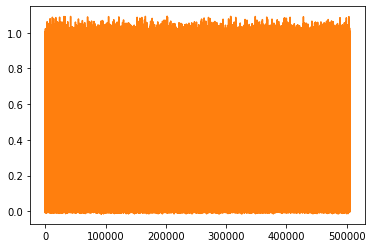

In [15]:
DNNpredtrain=modelDNN(X_train.to(device)).cpu().detach().numpy()

#
plt.plot(Y_train)
plt.plot(DNNpredtrain)

R2=r2_score(Y_train,DNNpredtrain)
MSE=mean_squared_error(Y_train,DNNpredtrain)*sc*sc
RMSE=np.sqrt(MSE)
print('R2=',R2,'\nMSE',MSE,'\nRMSE',RMSE)

R2= 0.9990780091403242 
MSE 0.4083399457158521 
RMSE 0.6390148243318398


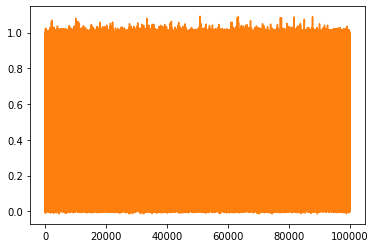

In [16]:
DNNpred=modelDNN(X_test.to(device)).cpu().detach().numpy()

#
plt.plot(Y_test)
plt.plot(DNNpred)
#R2=sum(y_test*y_test-DNNpred*DNNpred)/N

R2=r2_score(Y_test,DNNpred)
MSE=mean_squared_error(Y_test,DNNpred)*sc*sc
RMSE=np.sqrt(MSE)
print('R2=',R2,'\nMSE',MSE,'\nRMSE',RMSE)

# 保存模型

In [17]:
torch.save(modelDNN, 'modelDNN.pth')